In [1]:
%load_ext autoreload
%autoreload 2

In [192]:
from typing import Union
from math import pi

from functorch import vmap
from matplotlib.colors import CenteredNorm
import matplotlib.pyplot as plt
import pyro
from pyro.contrib.autoname.named import Dict
import pyro.distributions as dist
import torch
from torch import Tensor
import torch.nn.functional as F

from caustic.base import Base
from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.lenses import EPL, ThickLens, ThinLens
from caustic.sources import Sersic, Source
from caustic.utils import get_meshgrid


DEVICE = "cpu"

In [327]:
class Simulator(Base):
    def __init__(
        self,
        lens: Union[ThinLens, ThickLens],
        src: Source,
        cosmology,
        fov: float,
        n_pix: int,
        sigma_n: float,
        upsample_factor: int = 4,
    ):
        super().__init__()
        self.lens = lens
        self.src = src
        self.cosmology = cosmology
        self.sigma_n = sigma_n
        self.upsample_factor = upsample_factor

        # Construct grids
        res = fov / n_pix
        self._thx_fine, self._thy_fine = get_meshgrid(
            res / upsample_factor, upsample_factor * n_pix, upsample_factor * n_pix
        )
        self.thx, self.thy = get_meshgrid(res, n_pix, n_pix)

        # Fix cosmology parameters
        self.z_l = torch.tensor(1.1)
        self.z_s = torch.tensor(2.3)

    def simulate(self, x_lens, x_src):
        ax, ay = self.lens.alpha(
            self._thx_fine, self._thy_fine, self.z_l, self.z_s, self.cosmology, *x_lens
        )
        mu_fine = self.src.brightness(self._thx_fine - ax, self._thy_fine - ay, *x_src)
        mu = F.avg_pool2d(mu_fine[None, None, :, :], self.upsample_factor)[0, 0]
        pyro.deterministic("mu", mu)  # record in trace
        img = pyro.sample("img", dist.Normal(mu, self.sigma_n, validate_args=False))
        return img

    def sample(self):
        return self.simulate(self.sample_lens(), self.sample_src())

    def sample_lens(self):
        with scope(prefix="lens"):
            thx0 = pyro.sample("thx0", dist.Normal(0.0, 0.1))
            thy0 = pyro.sample("thy0", dist.Normal(0.0, 0.1))
            q    = pyro.sample("q",    dist.Uniform(0.5, 0.999))
            phi  = pyro.sample("phi",  dist.Uniform(0, 2 * torch.pi))
            b    = pyro.sample("b",    dist.Uniform(1.0, 1.2))
            t    = torch.tensor(3.0)
        return thx0, thy0, q, phi, b, t

    def sample_src(self):
        with scope(prefix="src"):
            thx0  = torch.tensor(0.0)
            thy0  = torch.tensor(0.0)
            q     = pyro.sample("q",     dist.Uniform(0.5, 0.999))
            phi   = pyro.sample("phi",   dist.Uniform(0.0, 2 * torch.pi))
            index = pyro.sample("index", dist.Uniform(3.8, 4.2))
            th_e  = pyro.sample("th_e",  dist.Uniform(4.5, 5.0))
            I_e   = pyro.sample("I_e",   dist.Uniform(3.0, 5.0))
        return thx0, thy0, q, phi, index, th_e, I_e

In [332]:
sim = Simulator(EPL(), Sersic(), FlatLambdaCDMCosmology(), 5, 100, 30)

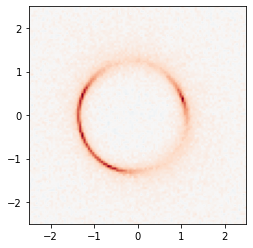

In [337]:
plt.imshow(
    sim.sample(),
    origin="lower",
    extent=(-2.5, 2.5, -2.5, 2.5),
    cmap="RdBu_r",
    norm=CenteredNorm(),
)

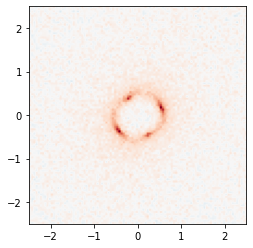

In [345]:
plt.imshow(
    pyro.condition(sim.sample, {"lens/b": torch.tensor(0.4)})(),
    origin="lower",
    extent=(-2.5, 2.5, -2.5, 2.5),
    cmap="RdBu_r",
    norm=CenteredNorm(),
)

In [346]:
trace = pyro.poutine.trace(sim.sample).get_trace()

print(f"log prob sum: {trace.log_prob_sum()}\n")

for site, values in trace.nodes.items():
    # if site.startswith("x_"):
    #     continue
    print(site)
    for k, v in values.items():
        print("    ", k, v)
    print()

log prob sum: -48365.94140625

_INPUT
     name _INPUT
     type args
     args ()
     kwargs {}

lens/thx0
     type sample
     name lens/thx0
     fn Normal(loc: 0.0, scale: 0.10000000149011612)
     is_observed False
     args ()
     kwargs {}
     value tensor(-0.0963)
     infer {}
     scale 1.0
     mask None
     cond_indep_stack ()
     done True
     stop False
     continuation None
     log_prob_sum tensor(0.9201)

lens/thy0
     type sample
     name lens/thy0
     fn Normal(loc: 0.0, scale: 0.10000000149011612)
     is_observed False
     args ()
     kwargs {}
     value tensor(-0.0937)
     infer {}
     scale 1.0
     mask None
     cond_indep_stack ()
     done True
     stop False
     continuation None
     log_prob_sum tensor(0.9446)

lens/q
     type sample
     name lens/q
     fn Uniform(low: 0.5, high: 0.9990000128746033)
     is_observed False
     args ()
     kwargs {}
     value tensor(0.6032)
     infer {}
     scale 1.0
     mask None
     cond_indep_s